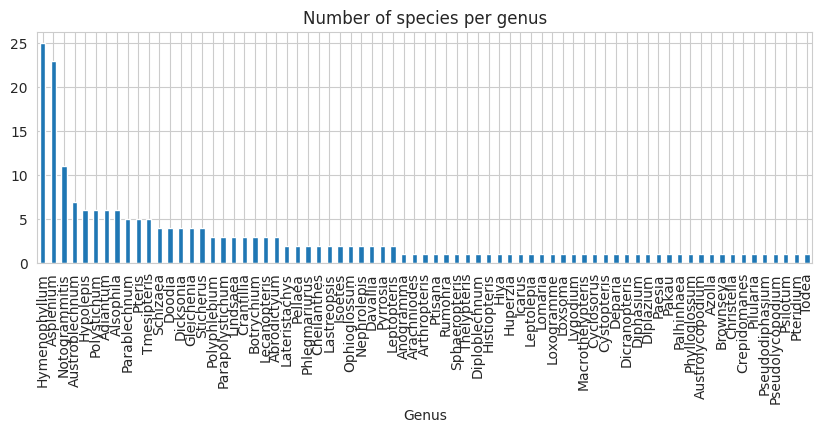

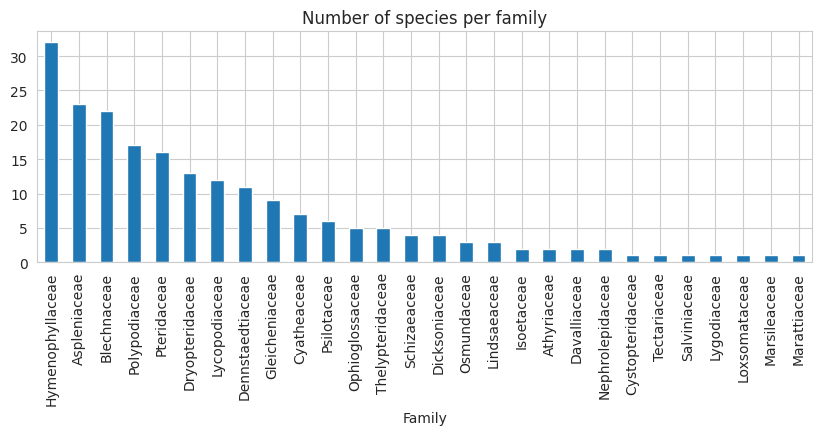

In [2]:
import pandas as pd
from PIL import Image
import numpy as np
import xarray as xr

from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
data_path = Path('Ferns')

def load_raster(f, grid_step=.1):
    raster = xr.open_dataarray(f)
    current_step = (raster.x[1] - raster.x[0]).values # degrees
    downsample = round(grid_step / current_step)
    raster = raster.coarsen(x=downsample, y=downsample, boundary="trim").sum()
    return raster

species_list = pd.read_excel(data_path / 'Species list.xlsx')
species_list.Genus.value_counts().plot(kind='bar', figsize=(10, 3), title='Number of species per genus')
plt.show()
species_list.Family.value_counts().plot(kind='bar', figsize=(10, 3), title='Number of species per family')
plt.show()

In [7]:
import sys
sys.path.append('..')
from loader import FernDataset

/home/smonaco/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
dataset = FernDataset(data_path)

RuntimeError: Dataset not found.

## Traits

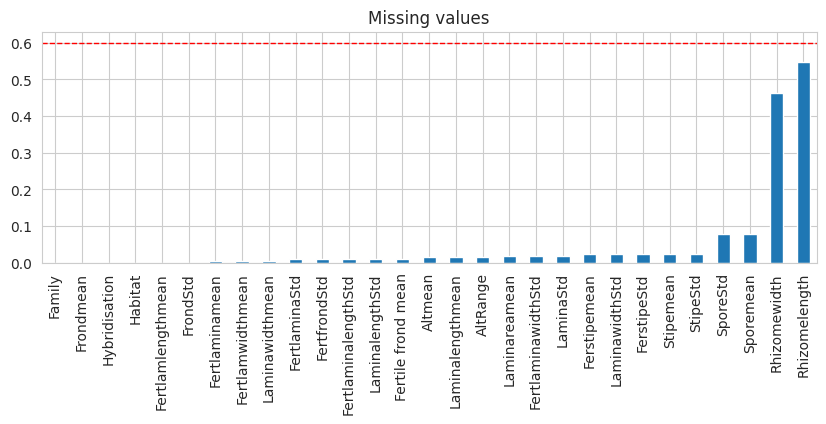

In [125]:
traits = pd.read_excel(data_path / 'Traits.xlsx')
traits_mean = pd.read_excel(data_path / 'Traits.xlsx', sheet_name='Mean').set_index('Species')
traits_var = pd.read_excel(data_path / 'Traits.xlsx', sheet_name='Var').drop(columns=['Family', 'Habitat', 'Hybridisation']).set_index('Species')
traits_std = traits_var.apply(np.sqrt).rename(columns=lambda x: x.replace('Var', 'Std'))

traits_all = traits_mean.join(traits_std)
traits_all = traits_all.drop(index='Hymenophyllum_falklandicum') # missing information
# traits_all.columns = traits_all.columns.map('_'.join)

fig, ax = plt.subplots(figsize=(10, 3))
(traits_all.isna().sum().sort_values() / len(traits_mean)).plot(kind='bar', ax=ax, title='Missing values')
plt.axhline(y=.6, color='r', linestyle='--', lw=1)
plt.show()

In [126]:
list(zip(sorted(traits_mean.columns[traits_mean.dtypes.eq('float64')&(traits_mean.columns!='Hybridisation')&~traits_mean.columns.str.startswith('Rhizome')]), sorted(traits_var.columns[traits_var.dtypes == 'float64'])))

[('Altmean', 'AltRange'),
 ('Ferstipemean', 'FerstipeVar'),
 ('Fertile frond mean', 'FertfrondVar'),
 ('Fertlaminamean', 'FertlaminaVar'),
 ('Fertlamlengthmean', 'FertlaminalengthVar'),
 ('Fertlamwidthmean', 'FertlaminawidthVar'),
 ('Frondmean', 'FrondVar'),
 ('Laminalengthmean', 'LaminaVar'),
 ('Laminareamean', 'LaminalengthVar'),
 ('Laminawidthmean', 'LaminawidthVar'),
 ('Sporemean', 'SporeVar'),
 ('Stipemean', 'StipeVar')]

In [127]:
for cl_feat in ['Habitat', 'Family']:
    for cl in traits_all[cl_feat].unique():
        if traits_all[cl_feat].eq(cl).sum() < len(traits_all) * 0.05:
            traits_all[cl_feat] = traits_all[cl_feat].replace({cl: 'Other'})
traits_all = pd.get_dummies(traits_all, drop_first=True)

class_idx = {
    'Habitat': [traits_all.columns.get_loc(c) for c in traits_all.columns if c.startswith('Habitat')],
    'Family': [traits_all.columns.get_loc(c) for c in traits_all.columns if c.startswith('Family')],
}
# df = df.drop(columns=[c for c in df.columns if c.startswith('Habitat') or c.startswith('Family')])

## Species Graph

In [64]:
from Bio import Phylo

# Load the tree
tree_file = data_path/"grafted_tree.nwk"
tree = Phylo.read(tree_file, "newick")

# Print a text-based visualization
Phylo.draw_ascii(tree)


                      _________ Anogramma_leptophylla
                     |
                     |   ______ Pteris_epaleata
                _____|  |
               |     |  |      , Pteris_macilenta
               |     |  |    __|
               |     |__|___|  | Pteris_saxatilis
               |        |   |
               |        |   |__ Pteris_tremula
               |        |
               |        |______ Pteris_carsei
            ___|
           |   |              , Cheilanthes_distans
           |   |          ____|
           |   |         |    | Cheilanthes_sieberi
           |   | ________|
           |   ||        |     , Pellaea_calidirupia
           |   ||        |_____|
           |   ||              | Pellaea_rotundifolia
           |   ||
           |   ||             , Adiantum_aethiopicum
           |    |             |
           |    |             | Adiantum_hispidulum
           |    |           __|
           |    |          |  |, Adiantum_cunninghamii
     

In [65]:
# tree to networkx
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
for clade in tree.get_nonterminals():  # Internal nodes (non-leaf)
    if clade.name is None:
        clade.name = f"temp_{id(clade)}"
    for child in clade.clades:
        if child.name is None:
            child.name = f"temp_{id(child)}"
        G.add_edge(clade.name, child.name, weight=child.branch_length)

# Visualize graph info
print("Graph nodes:", G.nodes())
print("Graph edges:", G.edges(data=True))

Graph nodes: ['temp_139109565197744', 'temp_139109561556032', 'temp_139108912768224', 'temp_139110450612320', 'Ptisana_salicina', 'temp_139108908999568', 'temp_139109561512160', 'temp_139108908992320', 'temp_139109561493520', 'temp_139109737600816', 'temp_139109561494576', 'temp_139109567114048', 'temp_139109561499328', 'temp_139109561513216', 'temp_139109561483584', 'temp_139109561506976', 'temp_139109561486944', 'temp_139109561513552', 'temp_139109561504816', 'temp_139109561502224', 'temp_139109561507360', 'Anogramma_leptophylla', 'temp_139109561501744', 'Pteris_epaleata', 'temp_139109561514320', 'Pteris_carsei', 'temp_139109561499872', 'Pteris_tremula', 'Pteris_macilenta', 'Pteris_saxatilis', 'temp_139109561511872', 'temp_139109561508416', 'temp_139109561505776', 'temp_139109561505920', 'Cheilanthes_distans', 'Cheilanthes_sieberi', 'Pellaea_calidirupia', 'Pellaea_rotundifolia', 'temp_139109561513744', 'Adiantum_formosum', 'temp_139109561511920', 'temp_139109561515232', 'Adiantum_aet

In [100]:
from node2vec import Node2Vec

# Train Node2Vec model
node2vec = Node2Vec(G, dimensions=16, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Create node embeddings
node_embeddings = {node: model.wv[node] for node in G.nodes()}

Computing transition probabilities: 100%|██████████| 374/374 [00:00<00:00, 47388.97it/s]


Generating walks (CPU: 2): 100%|██████████| 50/50 [00:01<00:00, 36.75it/s]


In [108]:
import itertools

leaf_nodes = [leaf.name for leaf in tree.get_terminals()]

G_species = nx.Graph()


# Compute pairwise phylogenetic distances between all leaves
for species1, species2 in itertools.combinations(leaf_nodes, 2):
    dist = tree.distance(species1, species2)  # Compute phylogenetic distance
    G_species.add_edge(species1, species2, weight=dist)

# Print some info
print("Total nodes (species only):", len(G_species.nodes))
print("Total edges before pruning:", len(G_species.edges))

median = np.median([d["weight"] for u, v, d in G_species.edges(data=True)])
print(f"Median distance: {median}\n")
sym_threshold = median

# Prune the graph by removing edges with weight > sym_threshold
edges_to_remove = [(u, v) for u, v, d in G_species.edges(data=True) if d["weight"] > sym_threshold]
G_species.remove_edges_from(edges_to_remove)
print("Number of connected components:", nx.number_connected_components(G_species))
print("Total edges after pruning:", len(G_species.edges))

Total nodes (species only): 190
Total edges before pruning: 17955
Median distance: 697.767902

Number of connected components: 7
Total edges after pruning: 9057


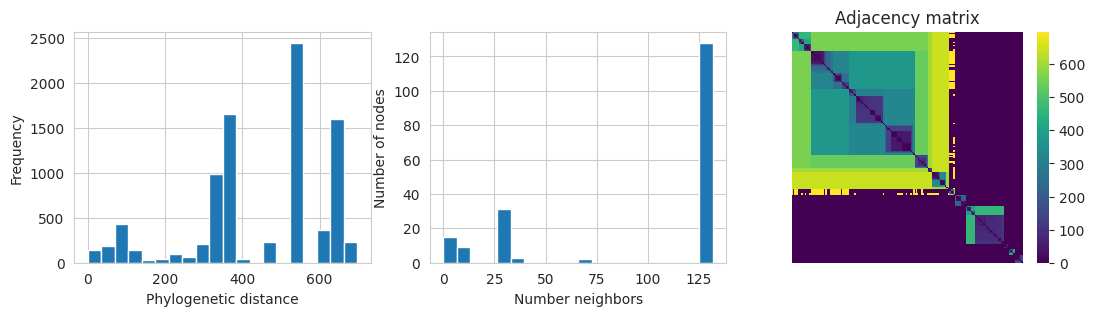

In [143]:
# histogram of the distances
fig, ax = plt.subplots(1, 3, figsize=(13, 3))
ax[0].hist([d['weight'] for _, _, d in G_species.edges(data=True)], bins=20)
ax[0].set_xlabel("Phylogenetic distance")
ax[0].set_ylabel("Frequency")

ax[1].set_xlabel("Number neighbors")
ax[1].set_ylabel("Number of nodes")
ax[1].hist([len(list(G_species.neighbors(n))) for n in G_species.nodes], bins=20)

sns.heatmap(nx.to_numpy_array(G_species), cmap="viridis", xticklabels=False, yticklabels=False, ax=ax[2], square=True)
ax[2].set_title("Adjacency matrix")
plt.show()

In [137]:
import torch
from torch_geometric.utils import from_networkx

# Remove species not present in the traits
G_species.remove_nodes_from(list(set(G_species.nodes).difference(traits_all.index)))

for node in G_species.nodes():
    G_species.nodes[node]["x"] = node_embeddings[node]
data = from_networkx(G_species)  # Include node attributes
data.node_names = [n for n in G_species.nodes()]  # Map node names to indices

# Add nodes not present in the ph_tree
for node in traits_all.index.difference(data.node_names):
    data.node_names.append(node)
    data.x = torch.cat([data.x, torch.zeros(1, data.num_features)], dim=0)

data.traits_nanmask = torch.tensor(traits_all.loc[data.node_names].isna().values, dtype=torch.bool)
data.traits = torch.tensor(traits_all.loc[data.node_names].fillna(0).astype(np.float32).values, dtype=torch.float32)

# Print PyG graph details
print(data)


Data(x=[206, 16], edge_index=[2, 17796], weight=[17796], node_names=[206], traits_nanmask=[206, 38], traits=[206, 38])


In [124]:
traits_all.loc[data.node_names]

,Family,Ferstipemean,Fertile frond mean,Fertlaminamean,Frondmean,Laminareamean,Rhizomelength,Rhizomewidth,Stipemean,Sporemean,...,FertlaminaStd,FrondStd,LaminaStd,StipeStd,SporeStd,AltRange,LaminalengthStd,LaminawidthStd,FertlaminalengthStd,FertlaminawidthStd
Species,,,,,,,,,,,,,,,,,,,,,
Anogramma_leptophylla,Pteridaceae,36.5,65.00,533.4000,28.50,131.2500,NaN,NaN,36.5,1166.000000,...,32.403703,6.082763,14.989997,7.549834,27.844808,24.186773,4.898979,3.316625,16.431677,5.656854
Pteris_epaleata,Pteridaceae,600.0,NaN,65520.0000,1250.00,NaN,NaN,NaN,600.0,NaN,...,361.994475,35.355339,NaN,24.494897,NaN,4.472136,NaN,NaN,4.000000,2.549510
Pteris_macilenta,Pteridaceae,445.0,875.00,143388.0000,875.00,143388.0000,5.50,0.95,445.0,1056.000000,...,529.361880,36.742346,529.361880,27.386128,27.313001,28.284271,27.748874,26.267851,3.464102,1.414214
Pteris_saxatilis,Pteridaceae,137.5,422.50,32235.0000,422.50,32235.0000,4.00,0.65,137.5,774.000000,...,248.052414,23.558438,248.052414,13.964240,22.420229,18.973666,20.000000,16.278821,4.582576,2.449490
Pteris_tremula,Pteridaceae,645.0,1330.00,241710.0000,1330.00,241710.0000,5.75,0.70,645.0,1165.333333,...,690.434646,47.116876,690.434646,32.403703,26.381812,23.452079,34.205263,28.635642,17.888544,12.041595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Phlegmariurus_varius,Lycopodiaceae,0.0,14.50,14.0700,14.50,14.0700,535.00,12.00,0.0,592.000000,...,4.442972,3.000000,4.442972,0.000000,19.061305,38.729833,3.000000,1.414214,9.327379,3.000000
Phylloglossum_drummondii,Lycopodiaceae,0.0,13.50,4.9350,13.50,4.9350,30.50,NaN,0.0,542.666667,...,2.632489,3.605551,2.632489,0.000000,18.348479,15.491933,3.605551,0.707107,7.874008,2.121320
Pseudodiphasium_volubile,Lycopodiaceae,0.0,3.75,1.8375,3.75,1.8375,NaN,1.40,0.0,657.333333,...,1.620185,1.581139,1.620185,0.000000,23.280893,32.403703,1.581139,1.000000,1.643168,0.836660


# Occurrences - Space graph

In [3]:
from pathlib import Path
import xarray as xr
from tqdm import tqdm

distributions_dir = data_path / 'Distribution layers'


In [5]:
def process_portion(files_list):
    for i, f in enumerate(tqdm(files_list)):
        raster = load_raster(f)
        raster_sum = raster if i == 0 else xr.concat([raster_sum, raster], dim='species').sum('species')
    return raster_sum

all_files_list = list(distributions_dir.glob('*.tif'))
i = 0
batch_size = 10

raster_sum = process_portion(all_files_list[i:i+batch_size])
space_df = raster_sum.isel(band=0).to_pandas().reset_index().melt(id_vars=['y'])
space_df = space_df[space_df.value > 0]

100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


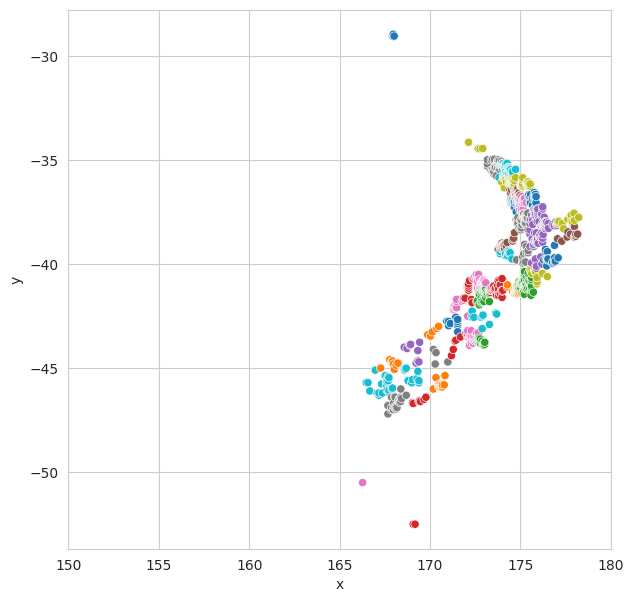

In [ ]:
# space_df = pd.read_csv(data_path / 'distriubtion_clusters.csv')
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=50, random_state=0).fit(space_df[['x', 'y']])
space_df['cluster'] = kmeans.labels_

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(data=space_df, x='x', y='y', hue='cluster', ax=ax, palette='tab10', legend=False)
plt.xlim(150, 180)
plt.show()

In [ ]:
from torch_geometric.data import Data
from torch_geometric.transforms import knn_graph

spatial_graph = Data(x=torch.tensor(self.space_df.groupby('cluster').agg({'x': 'mean', 'y': 'mean'}).values).float())
spatial_graph.edge_index = knn_graph(self.spatial_graph.x, k=6, batch=None)
spatial_graph.edge_attr = torch.norm(self.spatial_graph.x[self.spatial_graph.edge_index[0]] - self.spatial_graph.x[self.spatial_graph.edge_index[1]], dim=1).unsqueeze(1)

# Climate data

In [ ]:
clim_rasters = []
for f in tqdm(list((Path(data_path / "complete layers/climatic layers").rglob('*.tif')))):
    raster = load_raster(f)
    filt_raster = raster.interp(x=space_df.x.values, y=space_df.y.values, method='nearest').isel(band=0)
    filt_raster = filt_raster.to_pandas().reset_index().melt(id_vars=['y']).rename(columns={'value': f.stem})
    clim_rasters.append(space_df.set_index(['x', 'y']).join(filt_raster.set_index(['x', 'y'])).groupby(['cluster']).mean()[f.stem])
    break

100%|██████████| 29/29 [00:49<00:00,  1.72s/it]


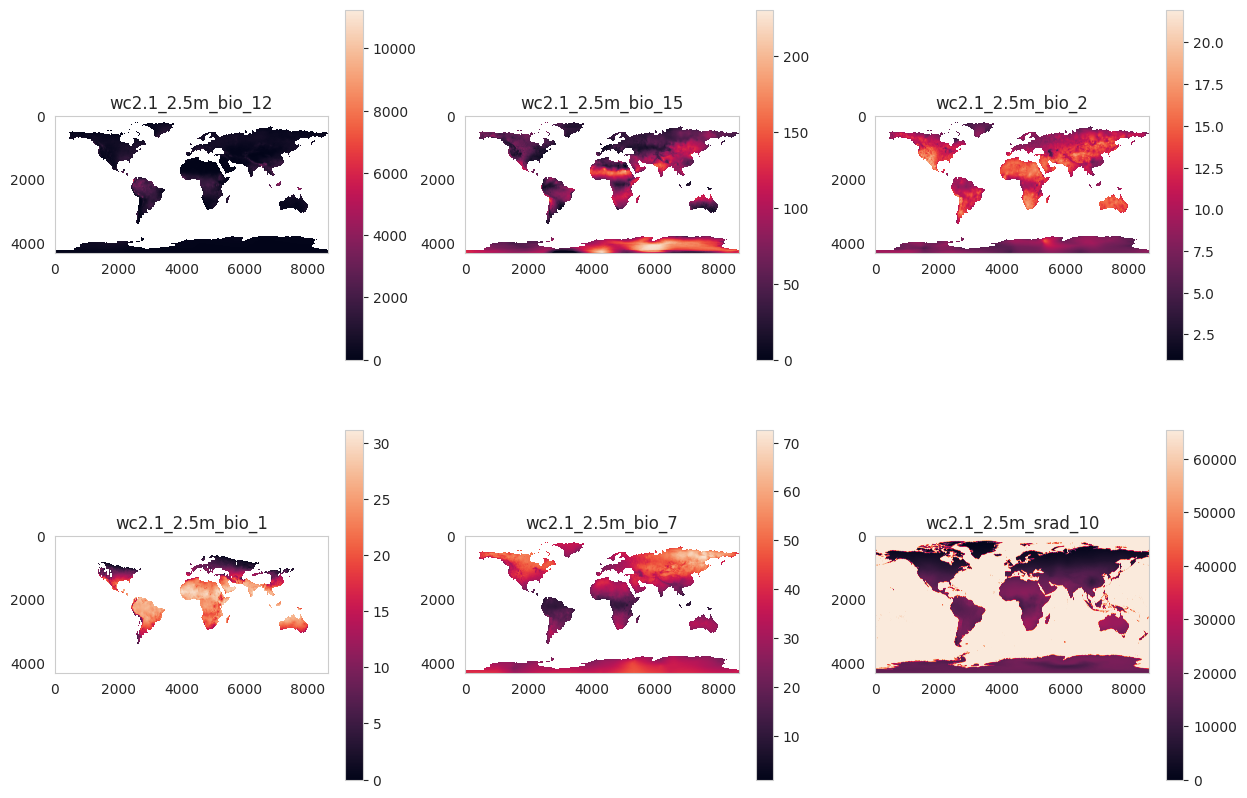

In [79]:
## Climatic heatmaps
# load tif image

fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for im_path, a in zip(Path('Ferns/complete layers/climatic layers').rglob('*.tif'), ax.flat):
    img = np.array(Image.open(im_path))
    # all numbers below 0 to np.nan
    if img.min() < 0:
        img[img < 0] = np.nan
    im = a.imshow(np.array(img))
    plt.colorbar(im)
    a.set_title(im_path.stem)
    a.grid(False)

# temp_clim = pd.DataFrame({'path': paths, 'size_0': [s[0] for s in sizes], 'size_1': [s[1] for s in sizes]})

In [70]:
raster_population#.rio.to_raster()

<xarray.DataArray 'band_data' (band: 1, y: 185, x: 3560)> Size: 3MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 28kB -176.9 -176.8 -176.7 ... 178.8 178.9 179.0
  * y            (y) float64 1kB -34.18 -34.28 -34.38 ... -52.38 -52.48 -52.58
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  14063.540039062
    STATISTICS_MEAN:     16.293056226496
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   175.35307491608

(-50.0, -34.0)

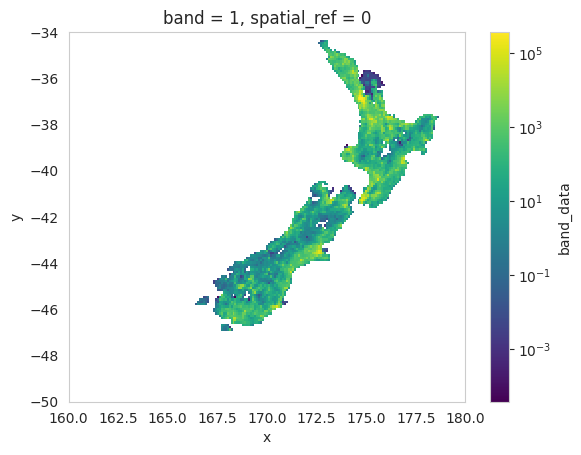

In [64]:
## Population
from matplotlib.colors import LogNorm

im_path = Path("Ferns/complete layers/population density and elevation layer/NZ population density layer.tif")
raster_population = load_raster(im_path)

xr.where(raster_population > 0, raster_population, np.nan).plot(norm=LogNorm())
plt.xlim(160, 180)
plt.ylim(-50, -34)

## Soil layers

(-50.0, -34.0)

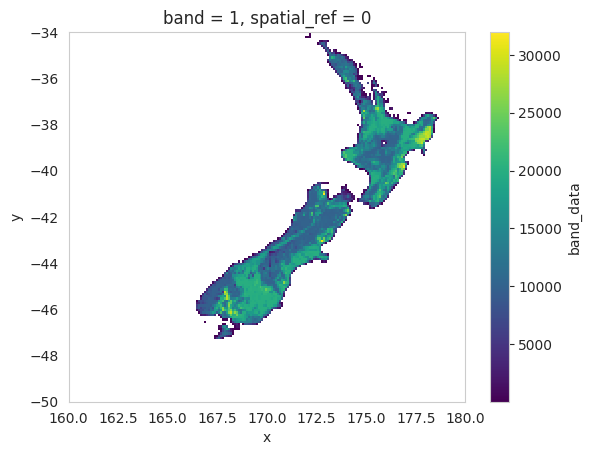

In [66]:
im_path = Path("Ferns/complete layers/Soil NZ layers/calciumraster.tif")
raster_soil = load_raster(im_path)

xr.where(raster_soil > 0, raster_soil, np.nan).plot()
plt.xlim(160, 180)
plt.ylim(-50, -34)